# IMaGES on ROI time series

In [1]:
import os
import pickle
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import pyplot, patches
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
from networkx.drawing import nx_pydot
import itertools
import copy
import mne

In [2]:
%matplotlib inline

In [3]:
sb.set_context('notebook')

In [4]:
def getdfs(csvdir):
    """
    give us list of data frames for csv files in directory.
    """
    dfs = []
    for csvfile in glob.glob(csvdir + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
    return dfs

In [5]:
def run_images_lofs(dfs,
                    withlofs=True,
                    lofsrule='R3',
                    lofsscore='andersonDarling',
                    maxdegree=30,
                    penalty=4):
    """
    run IMaGES and optionally LOFS post-processing on a given list of dataframes.
    Return the graph instance of either images or lofs output.
    """
    pc.start_vm() 
    
    images = s.imagesSemBic(dfs, verbose=True, maxDegree=maxdegree, penaltyDiscount=penalty)
    if withlofs:
        tetradGraph = images.getTetradGraph()    
        lofs = s.lofs(tetradGraph, dfs, dataType=0, rule=lofsrule, score=lofsscore)
    
        pc.stop_vm()
        return lofs
    else:
        pc.stop_vm()
        return images

In [86]:
def plot_svg(images_instance):
    """
    Take graph instance from IMaGES or LOFS and plot the SVG.
    
    """
    dot = images_instance.getDot()
    svg_str = dot.create_svg(prog='dot')
    SVG(svg_str)
    return dot

In [7]:
def save_dot2svg(dot, outname):
    """
    save svg from dot file & return svg
    """
    svg = dot.create_svg()
    with open(outname, 'w') as f:
        f.write(svg)
    return svg

## Preprocessed BOLD data

In [8]:
# directory with csv files for roi time series (seperate csv file for each run)
csvdir_allruns = pjoin('/host', 'famfaces', 'extract_meants', 'csv', 'allruns')
dfs = getdfs(csvdir_allruns)

In [9]:
lofs_raw = run_images_lofs(dfs)

In [85]:
plot_svg(lofs_raw)

In [11]:
## show nodes
nodes = [str(node) for node in lofs_raw.getNodes()]

In [12]:
## show edges
# lofs_raw.getEdges()

## Residuals

From a nuisance model with motion parameters, outliers, and button press as regressors.

In [13]:
# nuisance data with button press
dfs_nb = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', 'csv', 'run*'))

In [14]:
lofs_nb = run_images_lofs(dfs_nb)

In [15]:
plot_svg(lofs_nb)

## Residual data without button press as regressor

In [16]:
dfs_n = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance', 'csv', 'run*'))

In [17]:
lofs_n = run_images_lofs(dfs_n)

In [18]:
plot_svg(lofs_n)

# Extract directed edges from images object *manually*

TODO: These functions are not needed anymore (because replaced below). So save to some script before deleting.

In [19]:
def splitpair(pair):
    """
    split string containing two nodes into a tuple of two nodes.
    ignore directedness of connection.
    Used in get_adjacencies.
    """
    split = tuple([label.replace('- ', '').replace('> ', '').replace(' ', '') # looks ugly, but is supposedly faster
                   for label in pair.split('--')])
    return split

In [20]:
def get_adjacencies(images_instance):
    """
    returns a list of tuples of connected nodes (i.e. pairs)
    """
    
    # get edges and convert from unicode to string
    images_edges = images_instance.edges
    edgestrings = [str(edge) for edge in images_edges]
    
    # split the strings to get tuples, turn into arrays and sort
    edges = np.array([splitpair(pair) for pair in edgestrings])
    connections = edges[np.argsort(edges[:, 0])]
    
    return connections

# get undirected adjacency matrices

In [21]:
def get_undirected_AM(images_instance):
    """
    Get undirected adjacency matrix from an IMaGES or LOFS instance
    by detour via networkx
    """
    # get pydot from images instance
    dot = images_instance.getDot()
    # load dot to networkx
    graph = nx_pydot.from_pydot(dot)
    # make graph undirected
    graph_undir = graph.to_undirected()
        
    # get AM as numpy matrix, sorted by nodes alphabetically
    am = nx.to_numpy_matrix(graph_undir, dtype=np.bool, nodelist=sorted(graph.nodes()))
    return am

In [22]:
# AM of undirected graphs from preprocessed and residual data
am_und_raw = get_undirected_AM(lofs_raw)
am_und_nb = get_undirected_AM(lofs_nb)
am_und_n = get_undirected_AM(lofs_n)

# plot undirected connectivity with circular layout

In [23]:
def plot_connectivity_circle(undirected_AM, nodes, fsize=(10,10), title=None):
    """
    plot connectivity structure in circular layout using mne package.
    makes sense only for undirected graphs.
    """
    fig = plt.figure(figsize=fsize, facecolor='white')

    connect_kwargs = dict(
        facecolor = 'white',
        textcolor = 'black',
        fontsize_names=18,
        fontsize_colorbar=14,
        colormap = 'Greys',
        node_edgecolor='white',
        colorbar=False,
        interactive=False,
        node_linewidth=4,
        linewidth=2,
        vmin=0,
        vmax=1,
        show=False)

    f, ax = mne.viz.plot_connectivity_circle(np.array(undirected_AM), # change type from matrix to ndarray
                                     nodes,
                                     fig=fig, **connect_kwargs)
    if title:
        plt.title(title, fontweight='bold', fontsize=18)
    return fig

In [24]:
# alphabetically sorted list of nodes
sorted_nodes = sorted([str(node) for node in lofs_n.getNodes()])

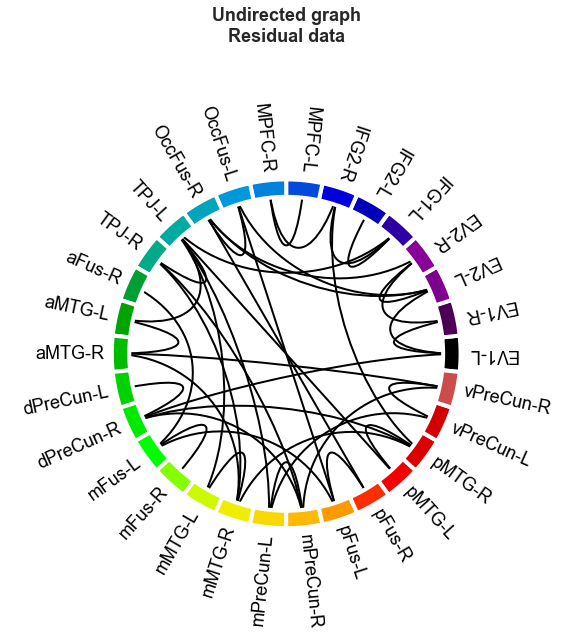

In [25]:
circ_und_n = plot_connectivity_circle(am_und_n, sorted_nodes, title='Undirected graph\nResidual data')

# Graph Matching methods

**Simple matching**

return the fraction of identical elements between two arrays

In [26]:
def simple_match(m1, m2):
    """
    return the relative number of identical elements between two arrays.
    """
    assert np.shape(m1) == np.shape(m2)
    return float(np.sum(m1 == m2)) / float(m1.size)

In [27]:
# simple matching graphs from preprocessed and residual data
match_residuals_preprocessed = simple_match(am_und_raw, am_und_nb)
print(match_residuals_preprocessed)

0.98


**Jaccard Index**

Use Scikit learn. Basically, the Jaccard index is the intersection divided by the union of two sets.

In [28]:
from sklearn.metrics import jaccard_similarity_score as jaccard

In [29]:
# jaccard index comparing graphs from preprocessed and residual data
jaccard(am_und_raw, am_und_nb)

0.81999999999999995

## Similarity across runs of undirected graphs (preprocessed data)

In [30]:
basedir = '/host/famfaces/extract_meants/csv'
rundirs_raw = [pjoin(basedir, 'run%03d' % i) for i in xrange(1,12)]

In [31]:
def csv2am_undirected(rundir):
    """
    based on csv directory, perform graph search and
    return undirected adjacency matrix of the represented graph
    """

    dfs = getdfs(rundir)
    images_instance = run_images_lofs(dfs)
    am = get_undirected_AM(images_instance)
    
    return am

In [32]:
def get_all_ams(rundirs):
    """
    get adjacency matrices of all runs
    """
    am_list = [csv2am_undirected(rundir) for rundir in rundirs]
    return am_list

In [33]:
## this command takes a while to execute
am_list = get_all_ams(rundirs_raw)

In [34]:
# save am_list as pickle
# with open('am_list.pickle', 'wb') as handle:
#    pickle.dump(am_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('am_list.pickle', 'rb') as handle:
#     am_list = pickle.load(handle)

In [35]:
def compare_runs(am_list, method='simple', symmetric=False):
    """
    pairwise comparison of matrices in a list of matrices.
    Choose between different measures of similarity.
    Choose if the input matrices are symmetric, due to undirected graphs.
    """
    
    if symmetric:
        am_list = [np.triu(am) for am in am_list]
    
    if method=='simple':
        match_list = np.array([
            [simple_match(am1, am2) for am1 in am_list]
            for am2 in am_list])
        
    if method=='jaccard':
        match_list = np.array([
            [jaccard(am1, am2) for am1 in am_list]
            for am2 in am_list])
        
    return match_list

In [36]:
def plot_match_matrix(match_matrix, ttl=None, axis=None):
    
    if axis:
        matrixplot = sb.heatmap(match_matrix, square=True, cmap='viridis', ax=axis)
    else:
        matrixplot = sb.heatmap(match_matrix, square=True, cmap='viridis')
    plt.xticks(np.arange(0.5, 11.5, 1), range(1,12))
    plt.yticks(np.arange(0.5, 11.5, 1), range(11,0,-1))
    
    if ttl:
        plt.title(ttl, fontweight='bold')

    print('minimum: ' + str(np.min(match_matrix)))
    print('maximum: ' + str(np.max(match_matrix)))
    print('mean: ' + str(np.mean(match_matrix)))

    return matrixplot

In [37]:
# simple matching of undirected adjacency matrices for preprocessed data
match_matrix_raw = compare_runs(am_list, symmetric=True)

In [38]:
def plot_clustered(matrix, colormap='viridis', meth='average',
                   dendrogram=False, ttl=None, colorbar=True):
    """
    Plot clustered correlation matrix using seaborn's clustermap.
    """

    clustermap = sb.clustermap(matrix, cmap='viridis', method=meth, figsize=(7,7),
                               xticklabels=range(1,12),
                               yticklabels=range(1,12))
    if not dendrogram:
        clustermap.ax_row_dendrogram.set_visible(False)
        clustermap.ax_col_dendrogram.set_visible(False)
    if not colorbar:
        clustermap.cax.set_visible(False)
    if ttl:
        clustermap.ax_heatmap.set_title(ttl, fontweight='bold', loc='center', fontsize=14)

    return clustermap

In [39]:
# jaccard index of undirected adjacency matrices for preprocessed data
jaccard_matrix_raw = compare_runs(am_list, method='jaccard', symmetric=True)

## Similarity across runs of DIRECTED graphs (preprocessed data)

In [40]:
def get_mixed_adjacency_dicts(images_instance):
    """x
    create a list of dicts, each containing the pair of nodes
    and wether edge is directed.
    """
    edgestrings = [str(edge) for edge in images_instance.edges]
    
    pairdicts = []
    for element in sorted(edgestrings):
        pairdict = {}
        if '-->' in element:
            pairdict['directed'] = True
            pair = element.split('-->')
        else:
            pairdict['directed'] = False
            pair = [word.replace('- ', '')
                    for word in element.split('--')]

        # remove whitespace and append
        pairdict['pair'] = [string.replace(' ', '') for string in pair]
        pairdicts.append(pairdict)
    return pairdicts

In [41]:
adjacency_dicts = get_mixed_adjacency_dicts(lofs_raw)
# show first few entries as example
adjacency_dicts[:5]

[{'directed': True, 'pair': ['EV1-R', 'EV1-L']},
 {'directed': True, 'pair': ['EV1-R', 'EV2-L']},
 {'directed': True, 'pair': ['EV1-R', 'EV2-R']},
 {'directed': True, 'pair': ['EV2-L', 'EV1-L']},
 {'directed': True, 'pair': ['EV2-L', 'EV2-R']}]

In [42]:
def mixed_am_from_images(images_instance):
    """
    Get adjacency matrix that allows undirected and directed edges
    from result of IMaGES by py-causal.
    """
    
    # get nodes and dict of adjacencies (mixed)
    adjacency_dicts = get_mixed_adjacency_dicts(images_instance)
    nodes = [str(node) for node in images_instance.nodes]

    # initiate empty matrix
    am = np.zeros((len(nodes),len(nodes)))
    
    for edgedict in adjacency_dicts:
        # find out node indices for source and target
        source_index = nodes.index(edgedict['pair'][0])
        target_index = nodes.index(edgedict['pair'][1])
        # fill in matrix
        am[source_index, target_index] = 1
        # for undirected edges, also fill in on other side of diagonal
        if not edgedict['directed']:
            am[target_index, source_index] = 1
    return am

In [43]:
def csv2mixed_am(rundir):
    """
    Use above to run IMaGES on csv directory and extract mixed adjacency matrix
    """
    dfs = getdfs(rundir)  
    images_instance = run_images_lofs(dfs)
    am = mixed_am_from_images(images_instance)
    return am

In [44]:
# get mixed adjacency matrices for preprocessed data
mixed_ams = [csv2mixed_am(rundir) for rundir in rundirs_raw]
np.shape(mixed_ams)

(11, 30, 30)

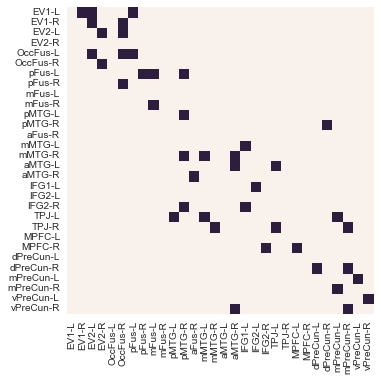

In [45]:
# inspect one random am
sb.heatmap(mixed_ams[1],
           cbar=False, square=True,
           xticklabels=nodes, yticklabels=nodes)

In [46]:
mixed_ams_n = [csv2mixed_am(rundir) for rundir in rundirs_raw]

In [47]:
# with open('mixed_ams.pickle', 'wb') as handle:
#     pickle.dump(mixed_ams, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
# simple matching of directed adjacency matrices from preprocessed data
simple_matches_directed = compare_runs(mixed_ams)

In [49]:
# jaccard index of directed adjacency matrices from preprocessed data
jaccard_directed = compare_runs(mixed_ams, method='jaccard')

## Similarity across runs of undirected graphs (residual data, with button press)

This is not to be used for the overview plot but rather just for completeness. We decided that regressing out button press might remove actual signal. Therefore, we want to focus on nuisance model with only motion and artifact regressors.

In [50]:
basedir_nb = '/host/famfaces/extract_meants_nuisance_button/csv'
rundirs_nb = [pjoin(basedir_nb, 'run%02d' % i) for i in xrange(1,12)]

In [51]:
# again, this takes a while. use pickle
am_list_nb = get_all_ams(rundirs_nb)

In [52]:
# save am_list_nb as pickle
#with open('am_list_nb.pickle', 'wb') as handle:
#    pickle.dump(am_list_nb, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
# Graph similarity (simple matching) across runs for residual data
match_matrix_nb = compare_runs(am_list_nb, symmetric=True)

In [54]:
# graph similarity (jaccard index) for residual data
jaccard_matrix_nb = compare_runs(am_list_nb, method='jaccard', symmetric=True)

## Similarity across runs of undirected graphs (residual data, without button press)

In [55]:
basedir_n = '/host/famfaces/extract_meants_nuisance/csv'
rundirs_n = [pjoin(basedir_n, 'run%02d' % i) for i in xrange(1,12)]

In [56]:
# list of undirected adjacency matrices
am_list_n = get_all_ams(rundirs_n)

In [57]:
# graph comparison
match_matrix_n = compare_runs(am_list_n, symmetric=True)
jaccard_matrix_n = compare_runs(am_list_n, method='jaccard', symmetric=True)

## Similarity across runs of DIRECTED graphs (residual data, without button press)

In [58]:
# list of directed adjacency matrices
am_list_directed_n = [csv2mixed_am(rundir) for rundir in rundirs_n]

In [59]:
# graph comparison
match_matrix_n_dir = compare_runs(am_list_directed_n, symmetric=True)
jaccard_matrix_n_dir = compare_runs(am_list_directed_n, method='jaccard', symmetric=True)

# Overview plot

In [60]:
def overview_plot(fonts=16, figs=(20,8), equal_limits=False):
    """
    Make an overview plot containing heatmaps in two rows, and four columns.
    Each heatmap represents graph similarity across runs.
    We plot seperate heatmaps for each similarity measure (jaccard vs. simple matching),
    data used (preprocessed vs. residual), and directionality of edges (undirected vs. directed).
    """
    # TODO: make this function more flexible
    
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=figs)
    
    # arguments for seaborn heatmap plot
    kwargs = {'xticklabels': range(1,12),
              'yticklabels': range(1,12),
              'cbar': True,
              'square': True,
              'cmap': 'viridis'}

    # set equal vmin and vmax to all color bars if desired 
    if equal_limits:
        kwargs['vmin'] = np.min([match_matrix_raw, jaccard_matrix_raw, simple_matches_directed,
                                 jaccard_directed, match_matrix_n, jaccard_matrix_n])
        kwargs['vmax'] = np.max([match_matrix_raw, jaccard_matrix_raw, simple_matches_directed,
                                 jaccard_directed, match_matrix_n, jaccard_matrix_n])
        
    # preprocessed data (left half of panel)

    positions_prep = [(0,0), (0,1), (1,0), (1,1)]
    matrices_prep = [match_matrix_raw, jaccard_matrix_raw, simple_matches_directed, jaccard_directed]
    titles_prep = ['simple matching\npreprocessed data', 'jaccard\npreprocessed data'] *2
        
    for mat, pos, ttl in zip(matrices_prep, positions_prep, titles_prep):
        heatmap = sb.heatmap(mat, ax=axs[pos], **kwargs)
        heatmap.set_title(ttl, fontweight='bold', fontsize=fonts)

    # residuals (right half of panel)

    positions_res = [(0,2), (0,3), (1,2), (1,3)]
    matrices_res = [match_matrix_n, jaccard_matrix_n, match_matrix_n_dir, jaccard_matrix_n_dir]
    titles_res = ['simple matching\nresidual data', 'jaccard\nresidual data'] *2

    for mat, pos, ttl in zip(matrices_res, positions_res, titles_res):
        heatmap = sb.heatmap(mat, ax=axs[pos], **kwargs)
        heatmap.set_title(ttl, fontweight='bold', fontsize=fonts)

    # turn off redundant axes
    axs[1,2].axis('off')
    axs[1,3].axis('off')
    
    # row labels
    rownames = ['undirected', 'directed']
    for ax, rowname in zip(axs[:,0], rownames):
        ax.set_ylabel(rowname, rotation=90, fontsize=fonts, fontweight='bold')
    
    return fig, axs

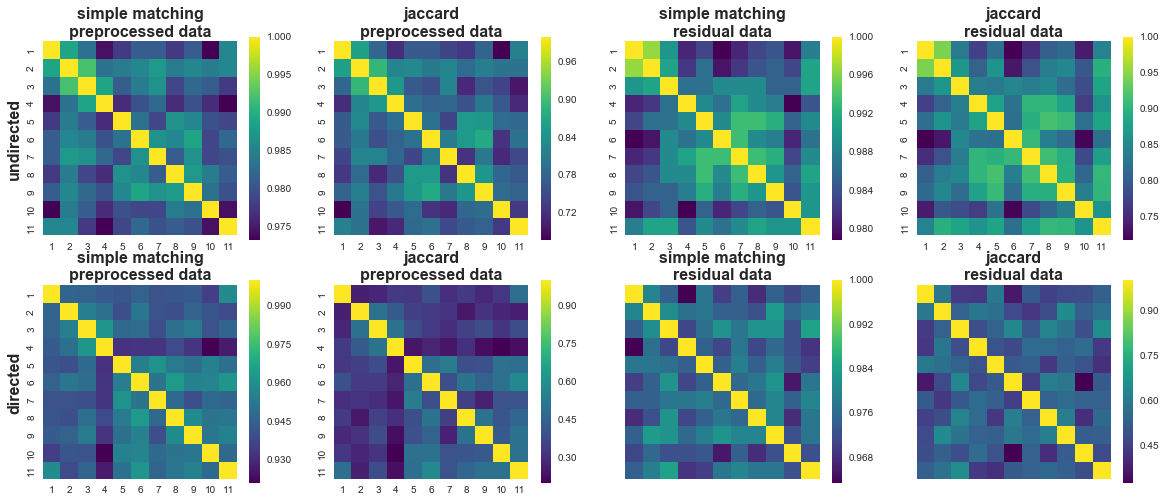

In [61]:
fig, axs = overview_plot()

In [62]:
# fig.savefig('overview_graphcomp_runs_withlofs.png', dpi=300)

# Influence of experimental stimulation

We modelled the influence of familiarity as a kind of differential regressor. For that purpose, stimulus onsets for familiar and unfamiliar faces respectively were convolved with a canonical HRF, and the result subtracted (familiar - unfamiliar).

See also the notebook 'model_contrast_for_tetrad.ipynb' and the script 'meants_tetrad.py'

## Residual data

In [63]:
path_withc_nb = pjoin('/host', 'famfaces', 'extract_meants_nuisance_button_withcontrast', 'sub*', 'csv', 'run*')

In [64]:
dfs_withc_nb = getdfs(path_withc_nb)

In [65]:
# perform images search
pc.start_vm() # start
images_withc_nb = s.imagesSemBic(dfs_withc_nb, verbose = True)
pc.stop_vm() # stop

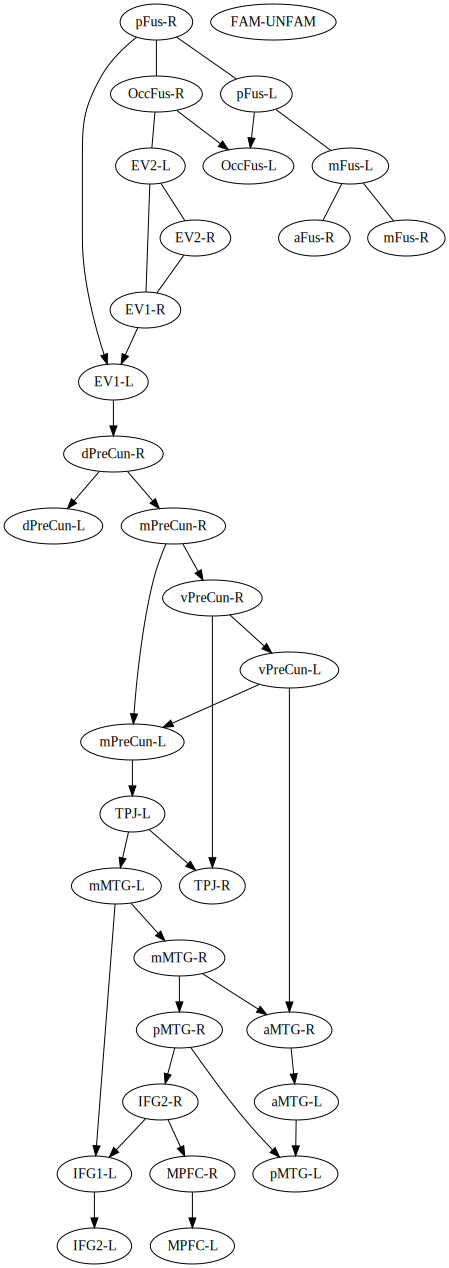

In [66]:
# render resulting graph
dot_withc_nb = images_withc_nb.getDot()
svg_str = dot_withc_nb.create_svg(prog='dot')
SVG(svg_str)

## Preprocessed data

In [67]:
path_withc_raw = pjoin('/host', 'famfaces', 'extract_meants_withcontrast', 'sub*', 'csv', 'run*')

In [68]:
dfs_withc_raw = getdfs(path_withc_raw)

In [69]:
# perform images search
pc.start_vm() # start
images_withc_raw = s.imagesSemBic(dfs_withc_raw, verbose = True)
pc.stop_vm() # stop

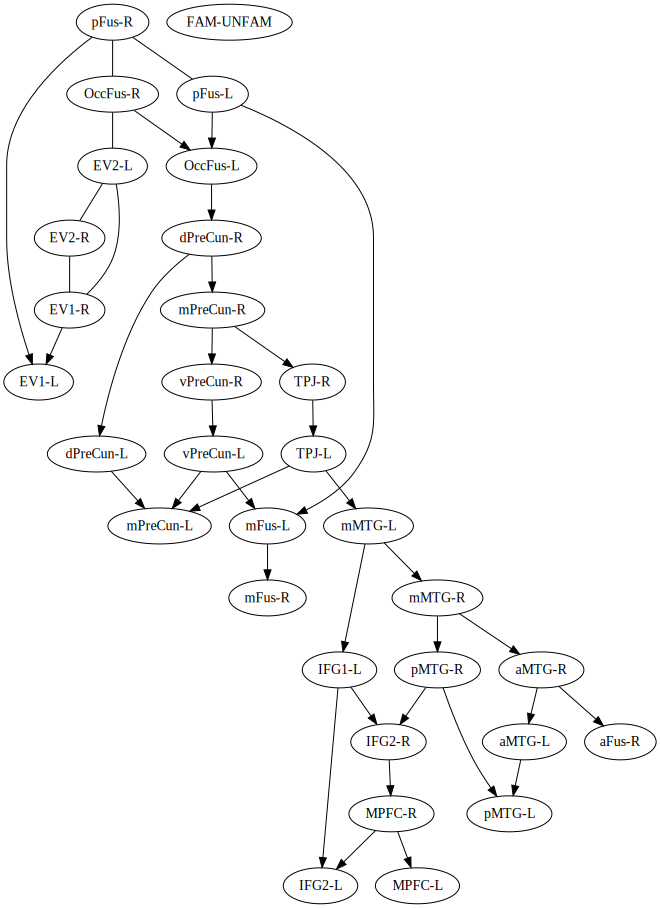

In [70]:
# render resulting graph
dot_withc_raw = images_withc_raw.getDot()
svg_str = dot_withc_raw.create_svg(prog='dot')
SVG(svg_str)

## Conclusion stimulus modelling

The constructed differential regressor (fam-unfam) does not fit in the graph, regardless of which data is used.

# AR modelling

Explore if AR modelling changes the failure to connect the familiarity effect to the rest of the network.

## Preprocessed data

In [71]:
from statsmodels.tsa.ar_model import AR

/Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [72]:
def ar_df(in_df, tr=2, lag=1):
    """
    perform AR modelling on all columns in a given data frame.
    Keep in mind that resulting data frame will be missing first row.
    """
    # don't change original data frames, make copy instead
    df = copy.deepcopy(in_df)
    
    # give df a timestamp as index
    df['time'] = range(tr,len(df)*tr+1,tr)
    df.index = pd.to_datetime(pd.to_timedelta(df['time'],unit='s'))
    df = df.drop('time', 1)
    
    # get column names
    header = list(df.columns.values)
    
    for cond in header:
        # autoregressive model
        ar_mod = AR(df[cond].astype(float), dates=df.index)

        fit = ar_mod.fit(lag)
        results = fit.predict()
        df[cond] = results # change respective column in df

    df = df.iloc[lag:] # don't include rows that are NaN due to AR
    
    return df

In [73]:
# perform AR modelling for all data frames based on preprocessed data
dfs_withc_raw_ar = [ar_df(df) for df in dfs_withc_raw]

In [74]:
# perform images search
pc.start_vm() # start
images_withc_raw_ar = s.imagesSemBic(dfs_withc_raw_ar, verbose = True)
pc.stop_vm() # stop

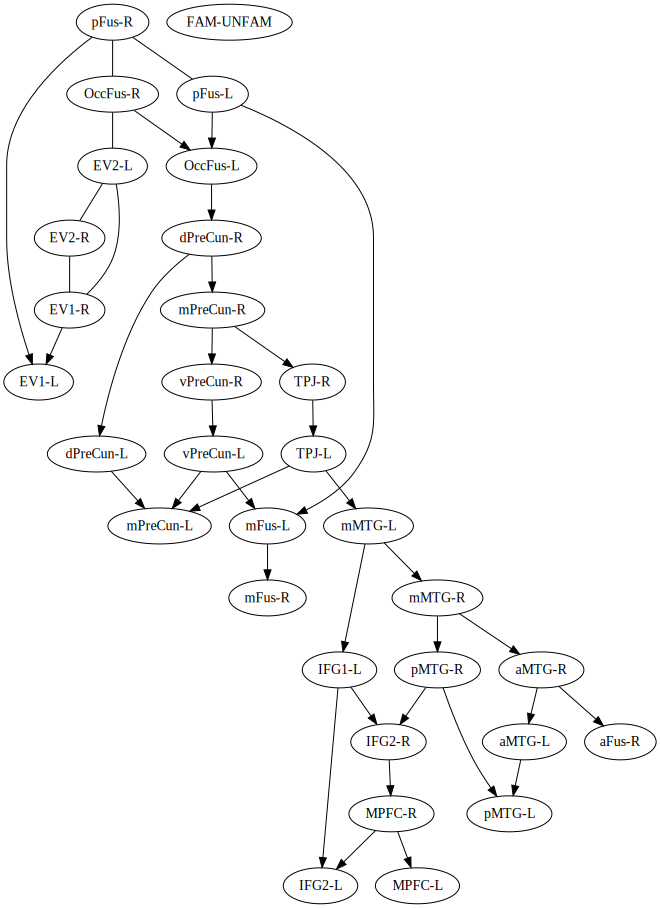

In [75]:
# render resulting graph
dot_withc_raw_ar = images_withc_raw_ar.getDot()
svg_str = dot_withc_raw_ar.create_svg(prog='dot')
SVG(svg_str)

In [76]:
sb.set_style('white')

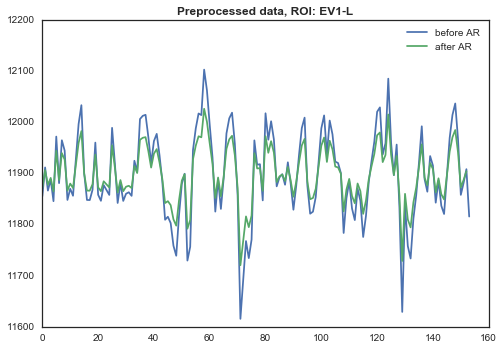

In [77]:
# time series of EV1-L before AR
plt.plot(dfs_withc_raw[0]['EV1-L'].values)
plt.plot(dfs_withc_raw_ar[0]['EV1-L'].values)
plt.legend(['before AR', 'after AR'])
plt.title('Preprocessed data, ROI: EV1-L', fontweight='bold')

## Residual data

In [78]:
# perform AR modelling for all data frames based on preprocessed data
dfs_withc_nb_ar = [ar_df(df) for df in dfs_withc_nb]

In [79]:
# perform images search
pc.start_vm() # start
images_withc_nb_ar = s.imagesSemBic(dfs_withc_nb_ar, verbose = True)
pc.stop_vm() # stop

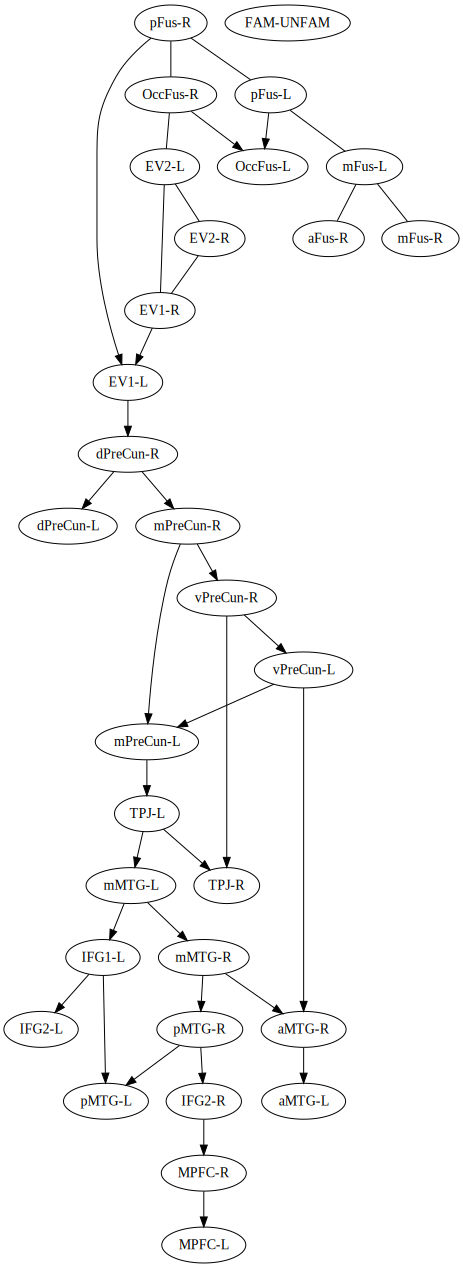

In [80]:
# render resulting graph
dot_withc_nb_ar = images_withc_nb_ar.getDot()
svg_str = dot_withc_nb_ar.create_svg(prog='dot')
SVG(svg_str)

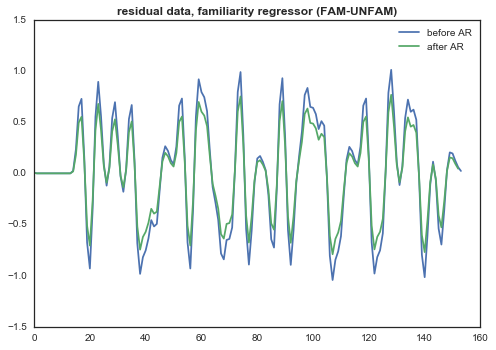

In [81]:
# example time series before AR in residual data
plt.plot(dfs_withc_nb[0]['FAM-UNFAM'].values)
plt.plot(dfs_withc_nb_ar[0]['FAM-UNFAM'].values)
plt.legend(['before AR', 'after AR'])
plt.title('residual data, familiarity regressor (FAM-UNFAM)', fontweight='bold')

## Conclusion AR modelling

AR modelling does not influence the graph (neither for preprocessed nor residual data).

# Which edges change?

Work in progress

## residual data

In [82]:
## reshape our list of adjacency matrices, so we can make a heatmap
## with 11 columns (for each run) and 900 rows (for each possible edge)

# np.shape(am_list_nb)
# am_list_nb_reshape = np.array(am_list_nb).reshape(900,11)
# np.shape(am_list_nb_reshape)

In [83]:
## plot heatmap

# fig, ax = plt.subplots(figsize=(18,30))
# hm = sb.heatmap(am_list_nb_reshape, cbar=False, xticklabels=False)